In [97]:
%load_ext autoreload
%autoreload 2

import torch
import tqdm
import gpytorch


import numpy as np
from ase import io
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import sys
sys.path.append("../../fande") # Adds higher directory to python modules path.
sys.path.append("..") # Adds higher directory to python modules path.

In [100]:
path = os.getcwd()

print(path)

/home/dlb/coding/shared_coding/repos/chem-gp/saddle-dynamics/notebooks


In [545]:
from fande.data import FandeDataModule

### Parsing and loading data:

In [15]:
%load_ext autoreload
%autoreload 2

from sdynamics.load import parse_trajectories, parse_forces, flatten_trj_dictionaries

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [625]:
trajectories, energies_trj, trj_files_basenames = parse_trajectories(traj_folder="../data/dynamics/ene_grad_fitting/data/trj/")
forces_trj = parse_forces(forces_path = '../data/dynamics/ene_grad_fitting/data/grad/', trj_files_basenames = trj_files_basenames)

Reading trajectory files...


100%|██████████| 50/50 [00:18<00:00,  2.77it/s]

Trajectory files reading done!
Reading .npy files with forces...
Reading .npy files with forces done!


In [626]:
traj, energies, forces = flatten_trj_dictionaries(trajectories, energies_trj, trj_files_basenames, forces_trj)

Flattening done!


### Prepare training/test datasets:

In [1109]:
# Training data:
# training_indices = np.sort(  np.random.choice(np.arange(0,10_000), 1000, replace=False) )
training_indices = np.sort(  np.arange(0, 10000, 50) )  
traj_train = [traj[i] for i in training_indices]
energies_train = energies[training_indices]
forces_train = forces[training_indices]
train_data = {'trajectory': traj_train, 'energies': energies_train, 'forces': forces_train}

#Test data:
# test_indices = np.sort(  np.random.choice(np.arange(0,92795), 200, replace=False) ) 
test_indices = np.sort(  np.arange(1,101,2) ) 
traj_test = [traj[i] for i in test_indices]
energies_test = energies[test_indices]
forces_test = forces[test_indices]
test_data = {'trajectory': traj_test, 'energies': energies_test, 'forces': forces_test}

In [1135]:
from fande.data import FandeDataModuleASE


hparams = {
    'dtype' : 'float64',
    'device' : 'gpu'
}

fdm = FandeDataModuleASE(train_data, test_data, hparams, atoms_forces=None)

In [1136]:
soap_params = {
    'species': ["H", "C"],
    'periodic': False,
    'rcut': 3.0,
    'sigma': 0.5,
    'nmax': 5,
    'lmax': 5,
    'average': "outer",
    'crossover': True,
    'dtype': "float64",
    'n_jobs': 10,
    'sparse': False,
    'positions': [0,2,3,6]
}

fdm.calculate_invariants(soap_params)

Total length of train traj is 200
Starting SOAP calculation...
SOAP calculation done!
Total length of test traj is 50
Starting SOAP calculation...
SOAP calculation done!
(200, 17, 3, 330)
(200, 330)


In [1120]:
fdm.train_DX.shape

torch.Size([10200, 330])

### Fitting Forces:

In [1121]:
from fande.models import ModelForces, ModelEnergies, MyCallbacks
from torch.utils.data import DataLoader, TensorDataset, random_split
from pytorch_lightning import Trainer, seed_everything
import numpy as np
# seed_everything(42, workers=True)

train_DX = fdm.train_DX
train_F = fdm.train_F
test_DX = fdm.test_DX
test_F = fdm.test_F

# ind_slice = np.sort( np.concatenate( 
#     ( np.arange(0,4800), np.arange(11*4800,12*4800), np.random.choice(np.arange(4800,59200), 300, replace=False) ) 
#     ) )

# ind_slice = np.sort(  np.random.choice(np.arange(0,train_F.shape[0]), 2_000, replace=False) ) 
# ind_slice = np.sort(  np.arange(0,2550) ) 
ind_slice = np.sort(  np.arange(0,train_F.shape[0]) ) 


train_dataset = TensorDataset(train_DX[ind_slice], train_F[ind_slice])
train_loader = DataLoader(train_dataset, batch_size=100_000)

model_f = ModelForces(train_DX[ind_slice], train_F[ind_slice], hparams, 0.05)

trainer_f = Trainer(
    gpus=1, 
    max_epochs=150, 
    precision=64,
    weights_summary='full', 
    callbacks=[MyCallbacks()])

trainer_f.fit(model_f, train_loader)

/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:394: UserWarning:

The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.




 setup() callback called...
Epoch 149: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it, loss=-1.93, v_num=187]  

 teardown() callback called...


### Predictions on test data:


 setup() callback called...

 on_predict_start() callback called...
Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]

 teardown() callback called...


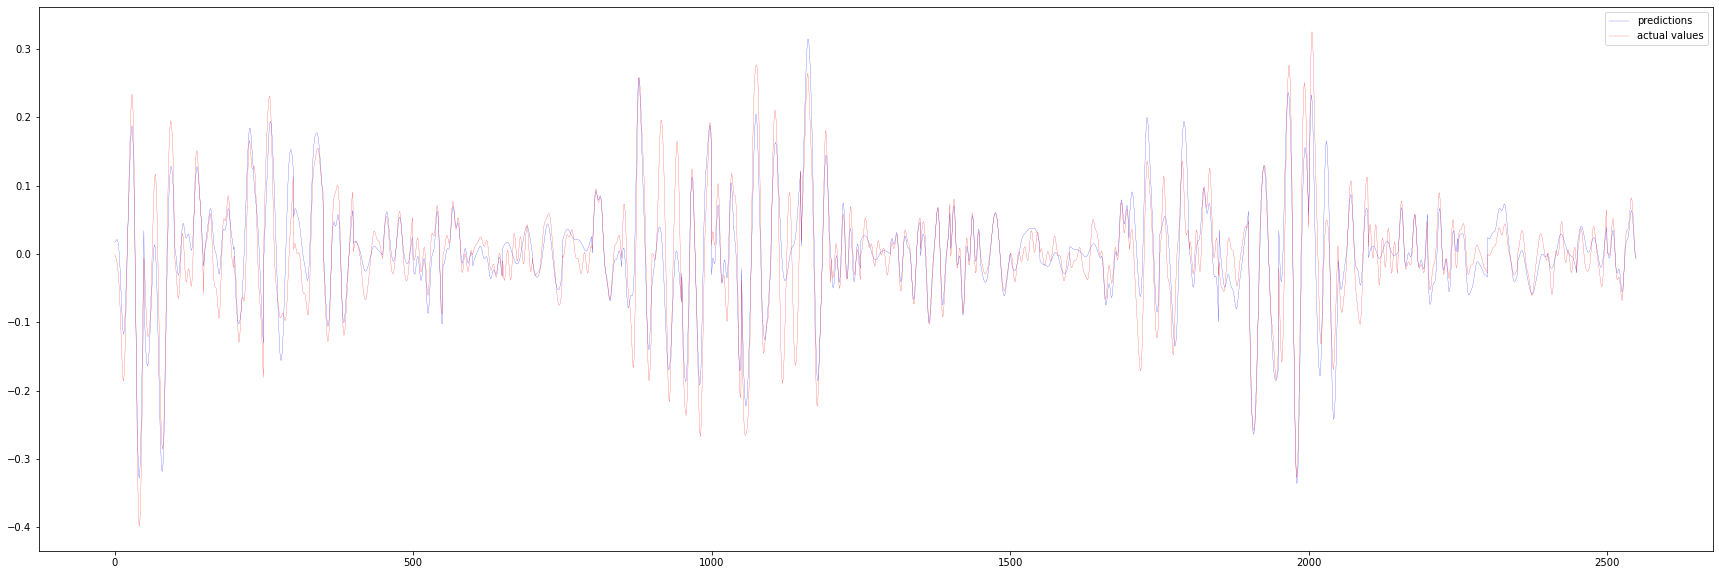

Forces MAE: 0.0278
Forces MSE: 0.0016


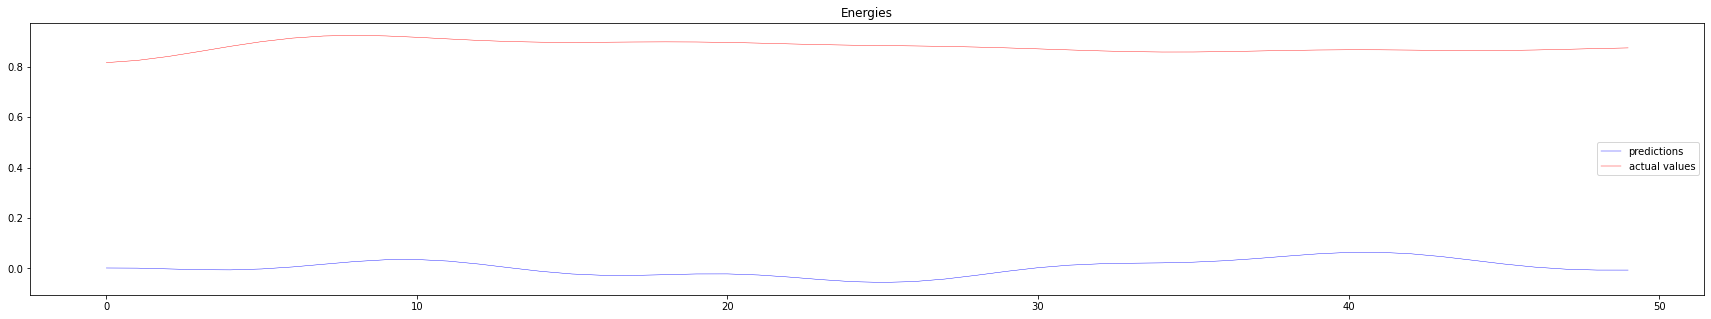

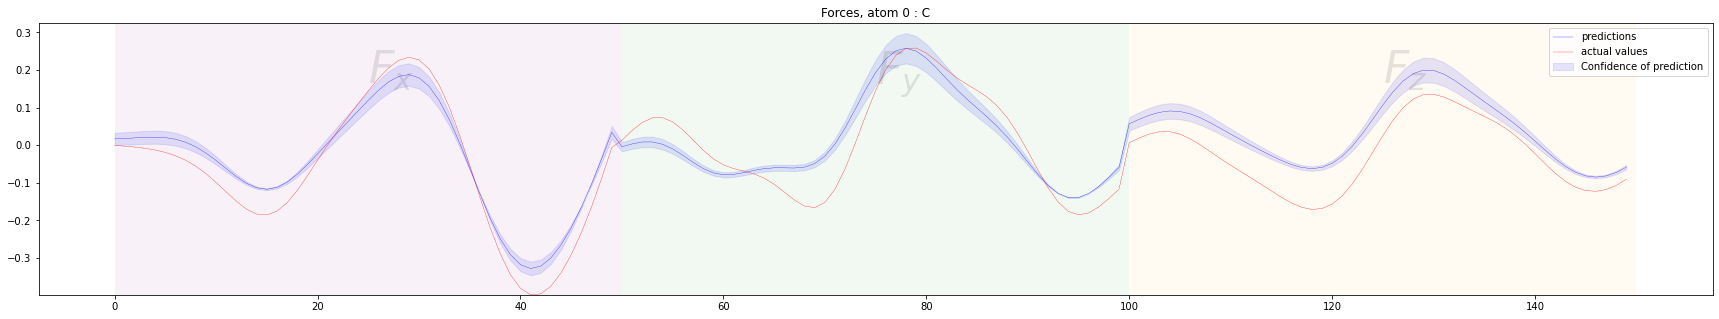

Forces MAE: 0.0519
Forces MSE: 0.0035
Cumulative uncertainty: 4.0220


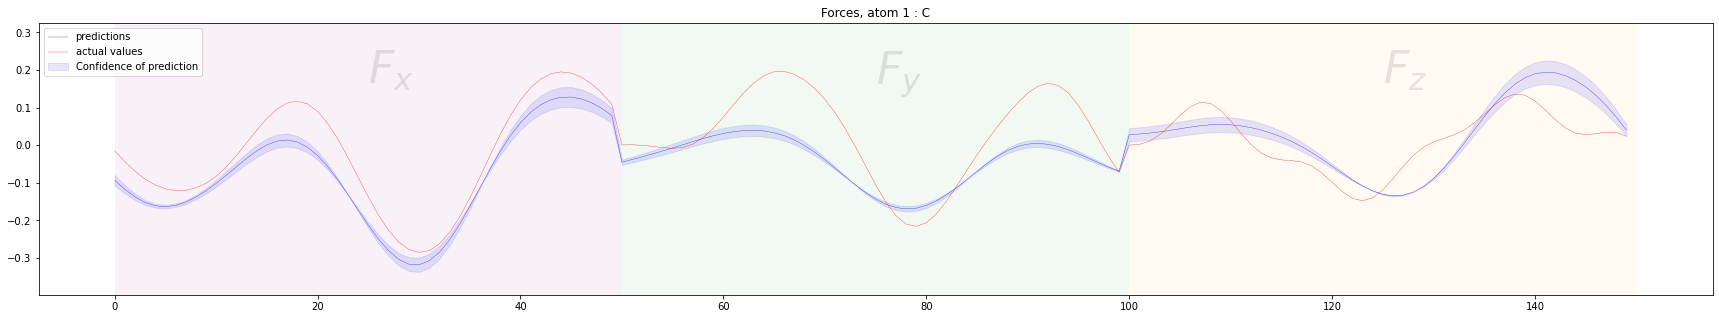

Forces MAE: 0.0623
Forces MSE: 0.0059
Cumulative uncertainty: 2.8028


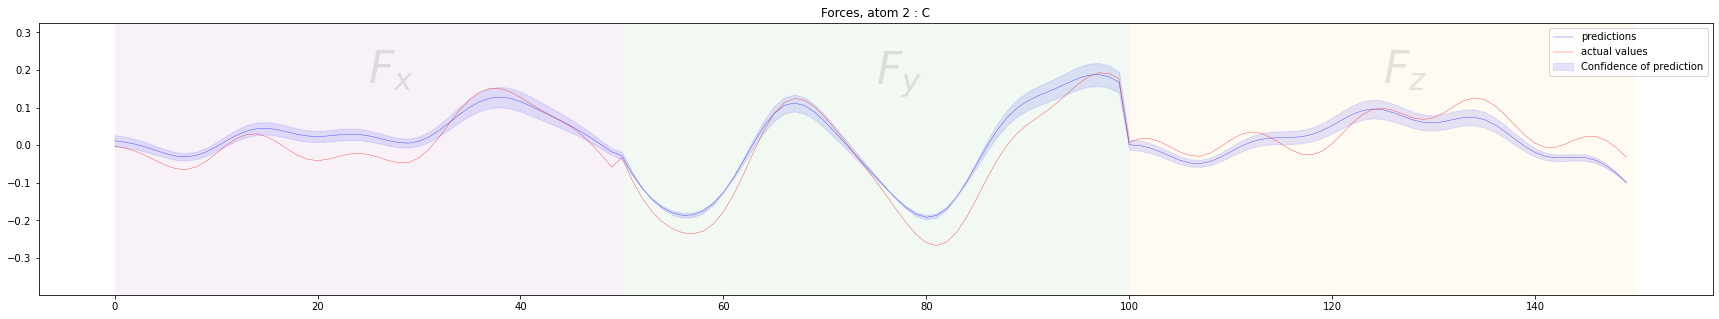

Forces MAE: 0.0321
Forces MSE: 0.0015
Cumulative uncertainty: 4.2073


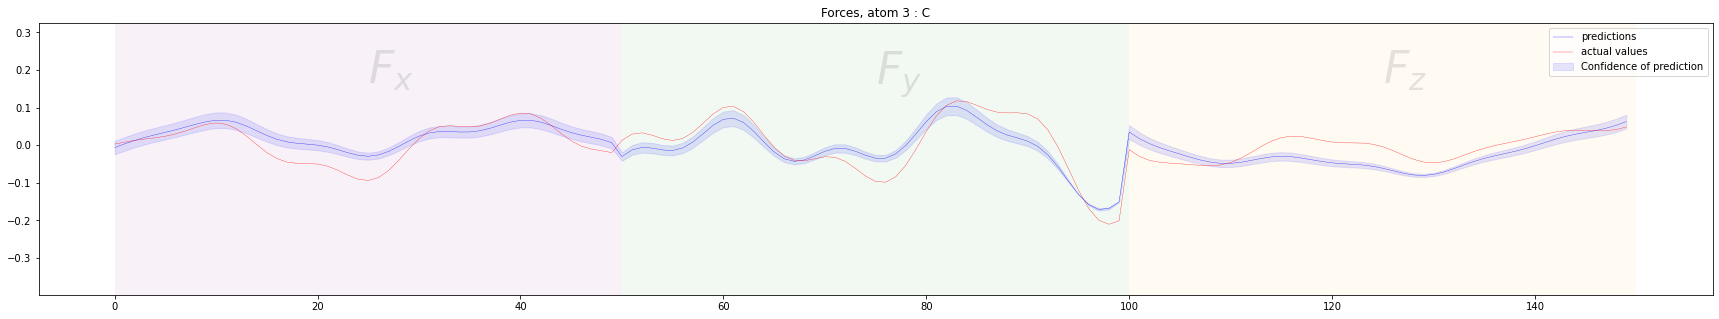

Forces MAE: 0.0304
Forces MSE: 0.0013
Cumulative uncertainty: 3.9137


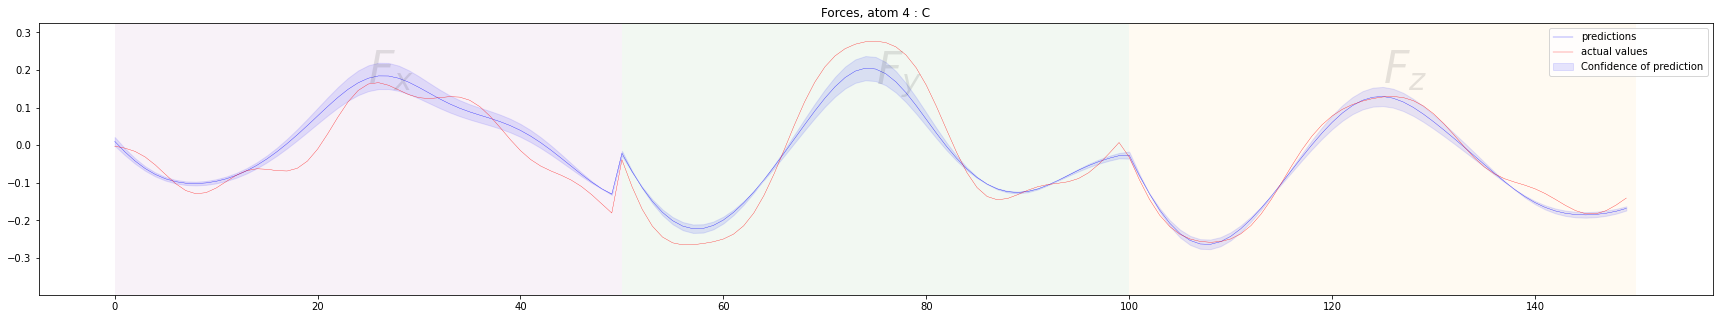

Forces MAE: 0.0301
Forces MSE: 0.0016
Cumulative uncertainty: 2.5901


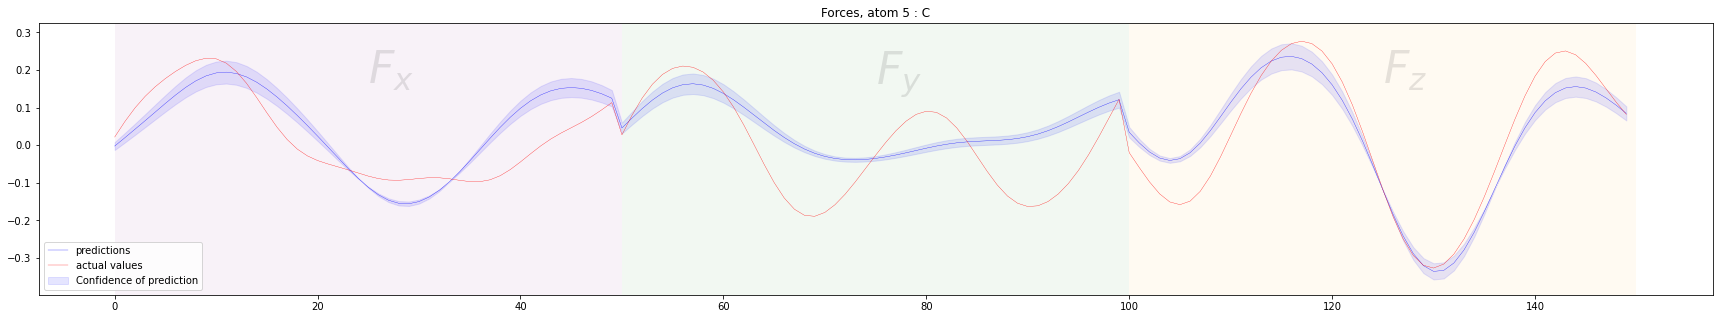

Forces MAE: 0.0677
Forces MSE: 0.0069
Cumulative uncertainty: 4.1753


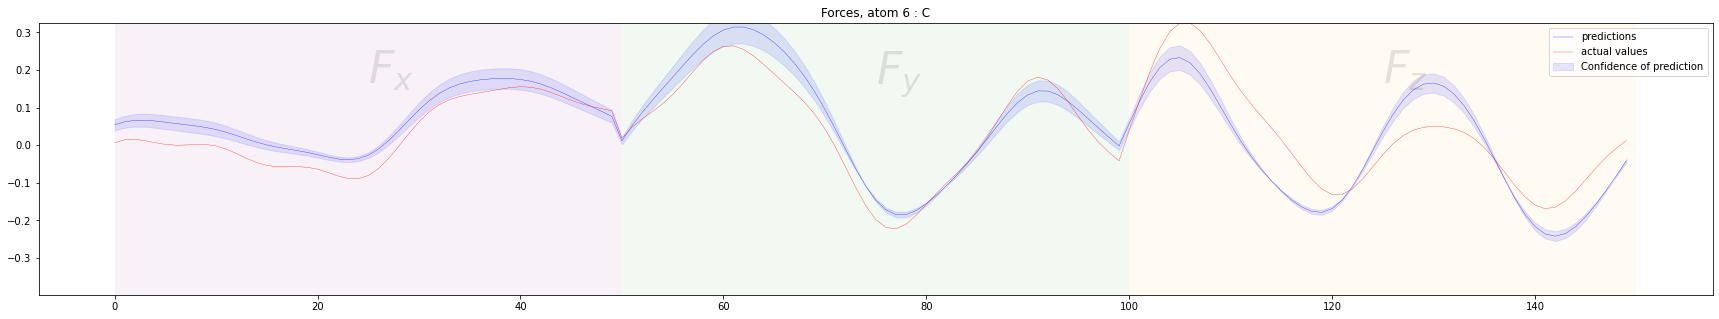

Forces MAE: 0.0502
Forces MSE: 0.0037
Cumulative uncertainty: 4.5081


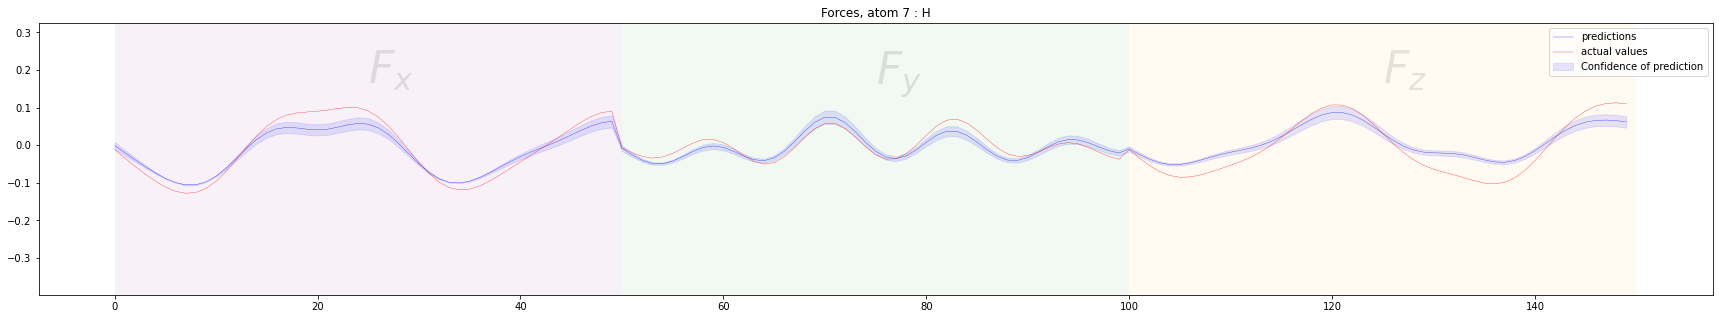

Forces MAE: 0.0212
Forces MSE: 0.0007
Cumulative uncertainty: 2.6274


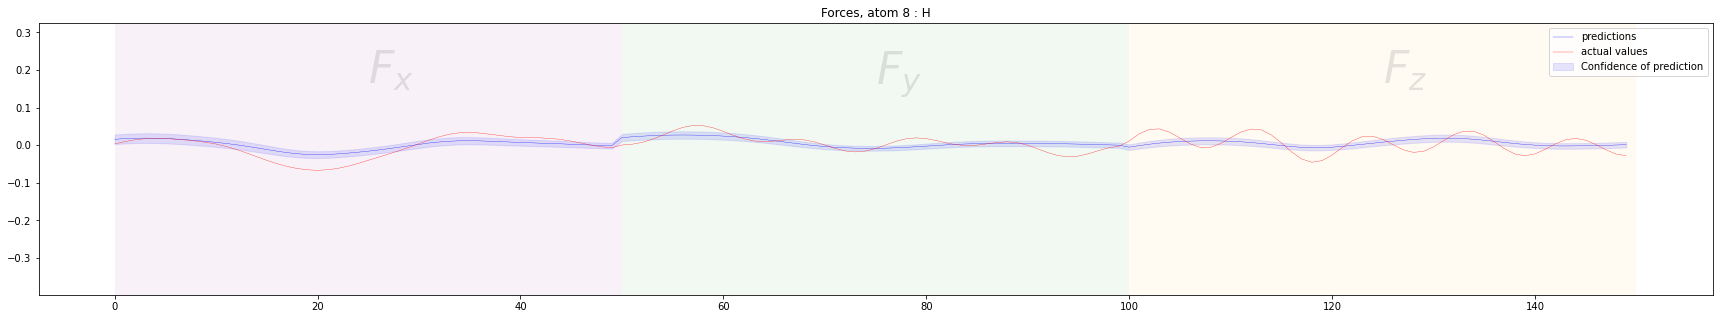

Forces MAE: 0.0157
Forces MSE: 0.0004
Cumulative uncertainty: 2.6089


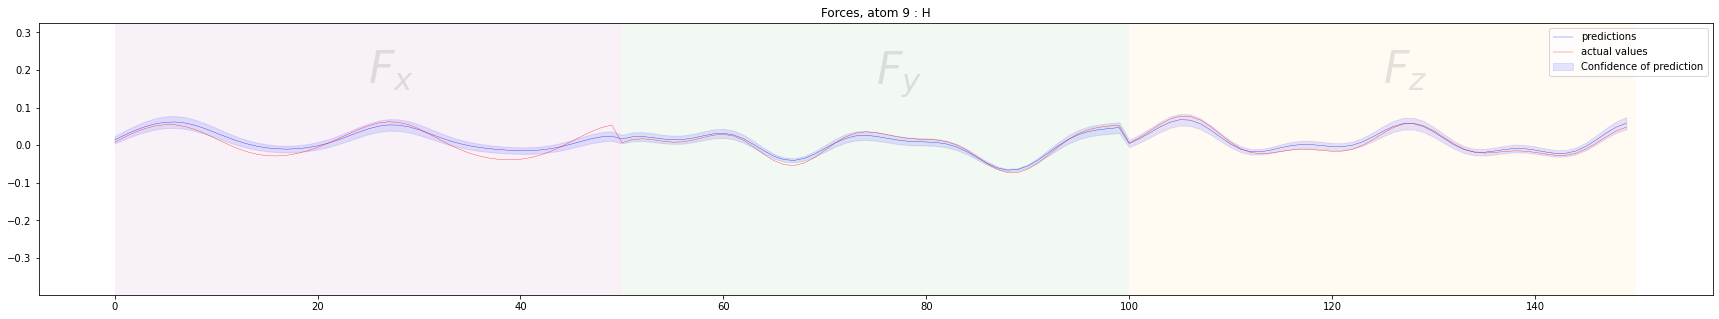

Forces MAE: 0.0084
Forces MSE: 0.0001
Cumulative uncertainty: 3.2145


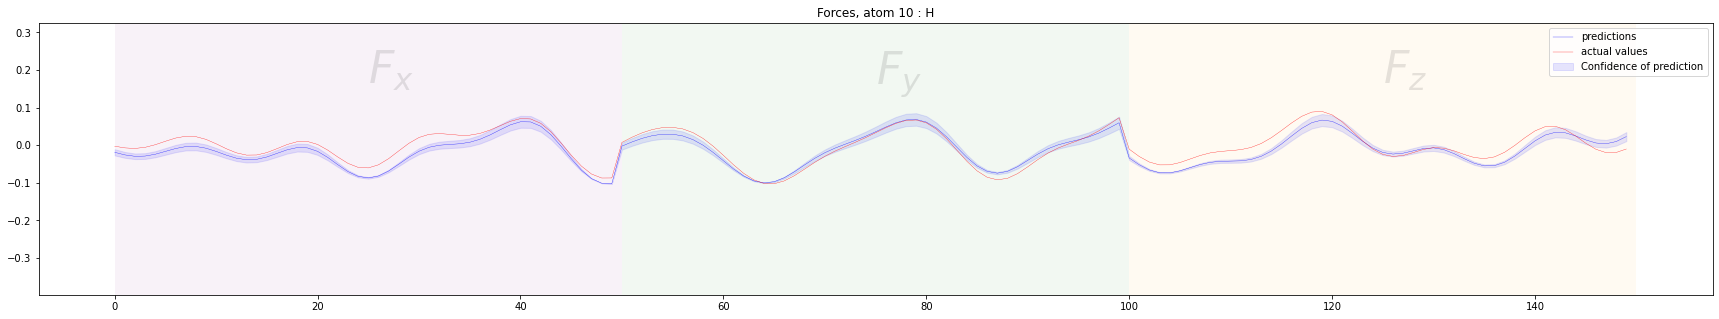

Forces MAE: 0.0161
Forces MSE: 0.0004
Cumulative uncertainty: 2.5495


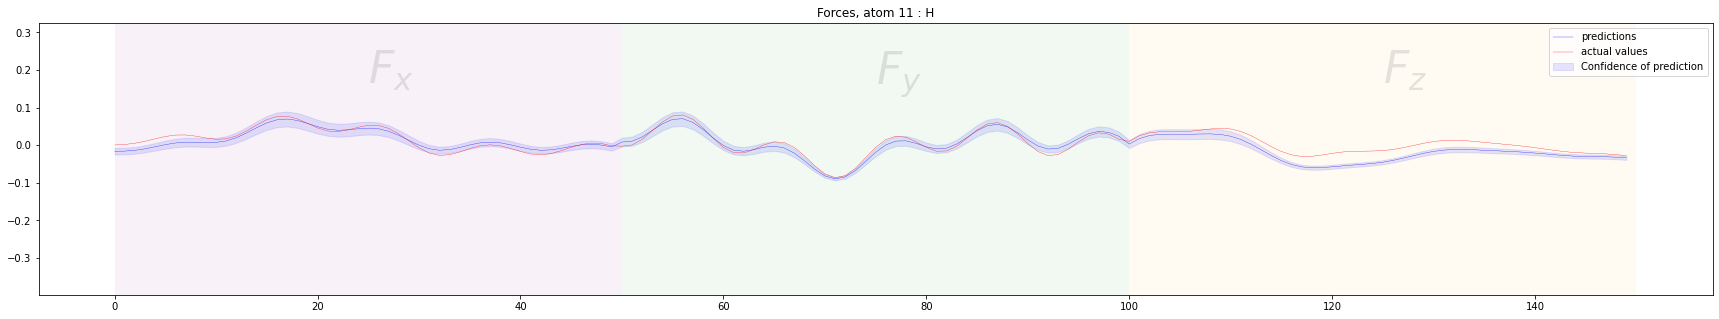

Forces MAE: 0.0120
Forces MSE: 0.0002
Cumulative uncertainty: 3.2672


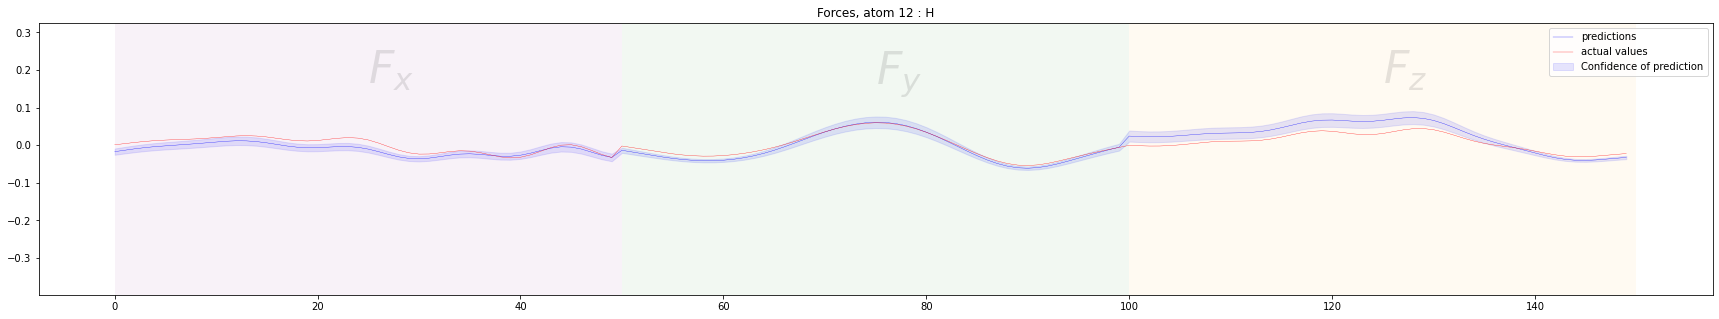

Forces MAE: 0.0130
Forces MSE: 0.0003
Cumulative uncertainty: 3.0888


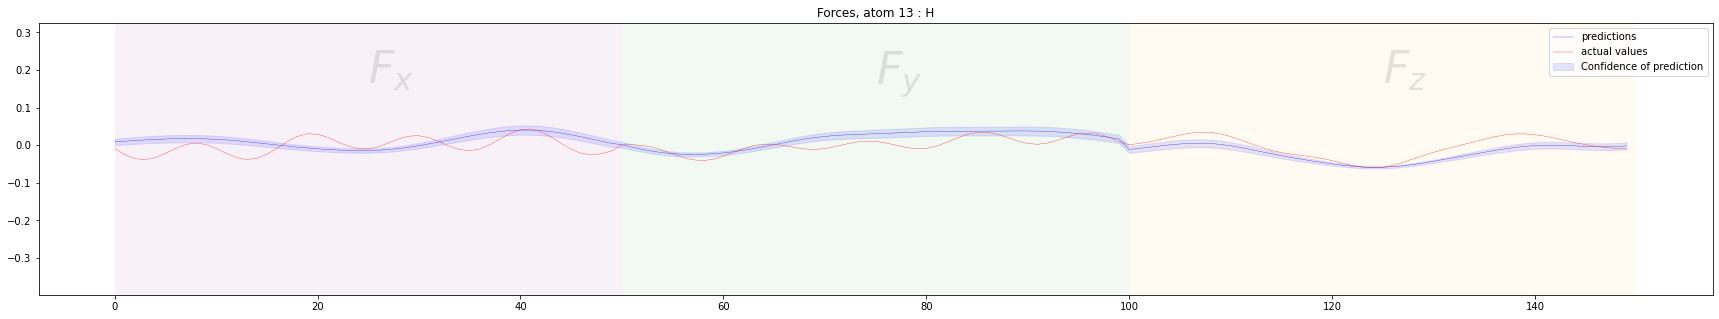

Forces MAE: 0.0197
Forces MSE: 0.0006
Cumulative uncertainty: 2.5677


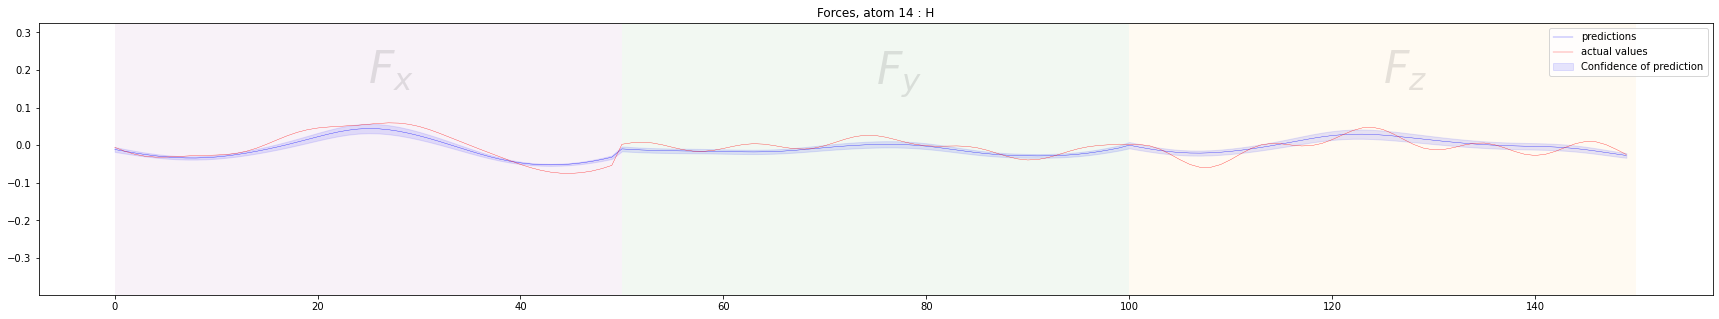

Forces MAE: 0.0128
Forces MSE: 0.0002
Cumulative uncertainty: 2.1893


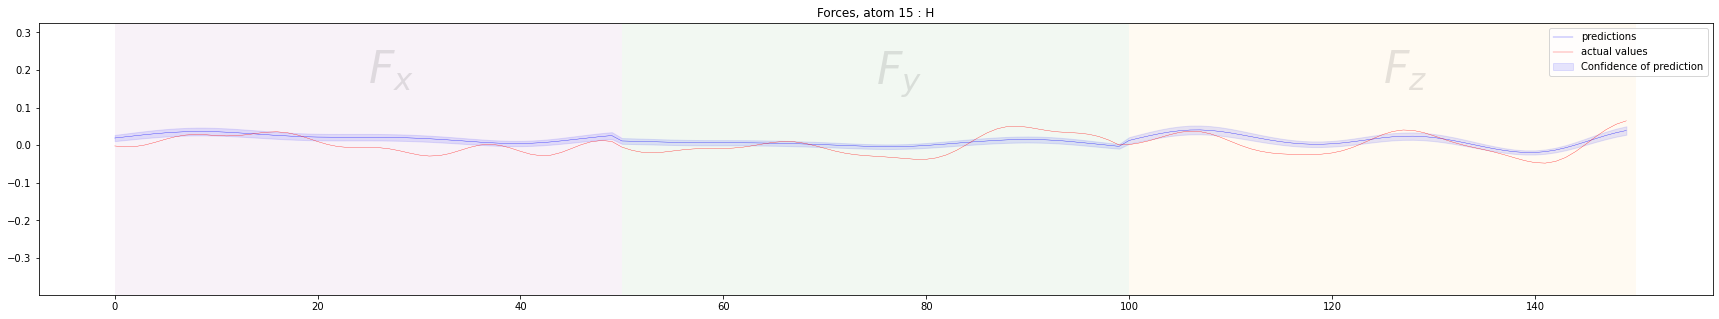

Forces MAE: 0.0188
Forces MSE: 0.0005
Cumulative uncertainty: 2.4384


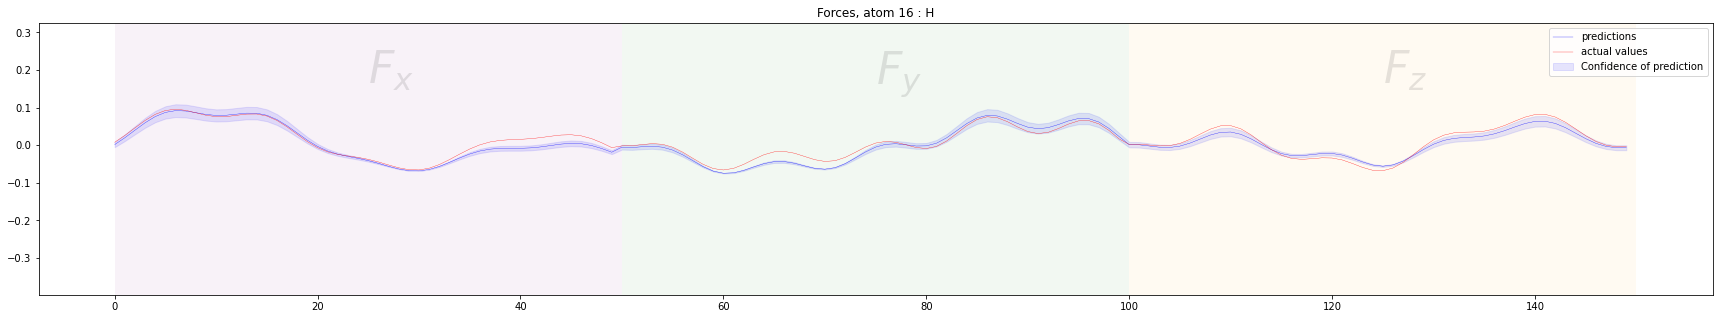

Forces MAE: 0.0098
Forces MSE: 0.0001
Cumulative uncertainty: 2.3841


In [1146]:
from fande.predict import PredictorASE

test_X = fdm.test_X
test_DX = fdm.test_DX
test_E = fdm.test_E
test_F = fdm.test_F

model_e = None
trainer_e = None


predictor = PredictorASE(
            model_e,
            model_f,
            trainer_e,
            trainer_f,
            test_X,
            test_DX,
            test_E,
            test_F,
            test_data,
            hparams,
            soap_params
)


predictor.predict_and_plot_forces()

In [1157]:
# %%capture


mol = fdm.traj_train[50].copy()
f_, f_var_ = predictor.predict_forces_single(mol)
# print(f_)

print(f_ - fdm.forces_train_norm[50,:,:])

Starting SOAP calculation...
SOAP calculation done!

 setup() callback called...

 on_predict_start() callback called...
Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]

 teardown() callback called...
[[ 0.00275413  0.0473063  -0.03824901]
 [-0.08797851 -0.1251158   0.03523719]
 [ 0.01444017  0.02981903 -0.01318817]
 [ 0.04748825  0.00881573  0.03295778]
 [ 0.01003921  0.00814021 -0.00187002]
 [ 0.04927667  0.05411044  0.08339261]
 [ 0.06288287  0.02535444 -0.06894186]
 [-0.00174145 -0.00280938  0.00083827]
 [-0.00494805  0.01970246  0.01959257]
 [-0.00018454 -0.00465101  0.01660744]
 [ 0.00710894  0.00575199 -0.010083  ]
 [-0.0009874  -0.0039853  -0.00358863]
 [-0.01697643 -0.01615409  0.02023217]
 [ 0.02713836 -0.01899443 -0.02237546]
 [-0.01326128  0.02458376  0.00361028]
 [ 0.01908563  0.03911926 -0.03194573]
 [-0.00996622  0.01159848 -0.00200719]]


### Dynamics simulation

In [ ]:
from sdynamics.dynamics import MDynamics

atoms = ... # initialize saddle structure

atoms.calc = gp_model.ase_calc() # get calc from the trained GP

md_runner = MDynamics(atoms) # instantiate class for running MD

md_runner.run() # run the MD

### Testing ASE calc

In [1062]:
%%time
from fande.ase import FandeCalc
from ase.build import molecule

from ase import io

import logging
logging.getLogger("pytorch_lightning").setLevel(logging.INFO) # logging.ERROR to disable or INFO


logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)


atoms = fdm.traj_train[0].copy()

# atoms = molecule("CH3CH2OCH3")
fande_calc = FandeCalc(hparams, model_e, trainer_e, model_f, trainer_f)

for a in traj: a.calc=fande_calc 

# print(atoms.get_potential_energy() )
print( atoms.get_forces())


RuntimeError: Atoms object has no calculator.

In [ ]:
### Molecular Dynamics with Fande calculator

In [1098]:
from sdynamics import MDRunner

In [1106]:
# %%capture
from sdynamics import MDRunner

# atoms = fdm.mol_traj[10].copy()
atoms = fdm.traj_train[0].copy()
atoms.calc = FandeCalc(predictor)

# print( atoms.get_forces() )
# print( atoms.get_potential_energy())

mdr = MDRunner(atoms, "../data/dump/ase/md_test.xyz", "../data/dump/ase/md_log.log")
mdr.run()

Starting SOAP calculation...
SOAP calculation done!

 setup() callback called...

 on_predict_start() callback called...
Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]

 teardown() callback called...
Starting SOAP calculation...
SOAP calculation done!

 setup() callback called...

 on_predict_start() callback called...
Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]

 teardown() callback called...
Starting SOAP calculation...
SOAP calculation done!

 setup() callback called...

 on_predict_start() callback called...
Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]

 teardown() callback called...
Starting SOAP calculation...
SOAP calculation done!

 setup() callback called...

 on_predict_start() callback called...
Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]

 teardown() callback called...
Starting SOAP calculation...
SOAP calculation done!

 setup() callback called...

 on_predict_start() callback called...
Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]

 teardown() call

In [1107]:
traj_ml = io.read("../data/dump/asemd.traj", index=":")
view(traj_ml)

<Popen: returncode: None args: ['/home/dlb/anaconda3/envs/pyc/bin/python', '...>

Traceback (most recent call last):
  File "/home/dlb/anaconda3/envs/pyc/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/dlb/anaconda3/envs/pyc/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/ase/gui/pipe.py", line 32, in <module>
    main()
  File "/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/ase/gui/pipe.py", line 28, in main
    plt.show()
  File "/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/matplotlib/pyplot.py", line 368, in show
    return _backend_mod.show(*args, **kwargs)
  File "/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/matplotlib_inline/backend_inline.py", line 41, in show
    display(
  File "/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/IPython/core/display_functions.py", line 265, in display
    print(*objs)
ValueError: I/O operation on closed file.


<Popen: returncode: None args: ['/home/dlb/anaconda3/envs/pyc/bin/python', '...>

Traceback (most recent call last):
  File "/home/dlb/anaconda3/envs/pyc/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/dlb/anaconda3/envs/pyc/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/ase/gui/pipe.py", line 32, in <module>
    main()
  File "/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/ase/gui/pipe.py", line 28, in main
    plt.show()
  File "/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/matplotlib/pyplot.py", line 368, in show
    return _backend_mod.show(*args, **kwargs)
  File "/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/matplotlib_inline/backend_inline.py", line 41, in show
    display(
  File "/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/IPython/core/display_functions.py", line 265, in display
    print(*objs)
ValueError: I/O operation on closed file.


### Visualize:

In [519]:
from ase.visualize import view

# trj = trajectories[trj_files_basename[2]]
view(traj[0:100])
# view(traj[0:100])

<Popen: returncode: None args: ['/home/dlb/anaconda3/envs/pyc/bin/python', '...>